# Importing packages

In [1]:
from workers import MasterNode
from models import MulticlassLogReg
from utils import read_run, get_alg, create_plot_dir, PLOT_PATH
from sklearn.datasets import dump_svmlight_file

import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prep_data import number_of_features, load_data_npy
import math
import torch
from torch import nn
import torch.nn.functional as F
from tensorflow.keras.metrics import Recall

from numpy.random import default_rng
from numpy import linalg as la
from prep_data import DATASET_PATH
import copy
import pickle
import sys
from multiprocessing import Process
import time
import matplotlib as mtl

from models import Node

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Customizing Matplotlib

In [2]:
plt.style.use('fast')
mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'

In [3]:
markers = ['x', '.', '+', '1', 'p','*', 'D' , '.',  's']

In [4]:
MODELS_PATH = 'models/'

# Basic experimental setup

In [5]:
exp_keyword = 'SO_LR_one_cluster_50'

In [266]:
exp_keyword

'SO_LR_one_cluster_50'

In [6]:
dataset_name = exp_keyword + '.npz'

In [7]:
n_workers = 50

In [8]:
alpha = 0.5
worker = MulticlassLogReg
logreg = True
multilabel = True
d_y = 500
regularization = 0
tolerance = 1e-2
val_rat = 0.2
validation = True
compute_smoothness_min = False
npz = True
max_it = 1

In [9]:
mixed_model = MasterNode(n_workers, 
                         alpha, 
                         worker, 
                         dataset_name, 
                         logreg, 
                         max_it=max_it,                         
                         compute_smoothness_min=compute_smoothness_min,
                         validation=validation,
                         val_rat=val_rat,
                         multilabel=multilabel, 
                         d_y=d_y, 
                         regularization=regularization,
                         tolerance=tolerance,
                         npz=npz)

In [10]:
mixed_model.d

5000500

In [11]:
type(mixed_model.workers[0].x_train)

numpy.ndarray

In [12]:
type(mixed_model.workers[0].y_train)

numpy.ndarray

Let us check the label distribution is "fine".

In [13]:
y_all = np.empty(shape=(0, 500))
for i in range(mixed_model.n_workers):
    y_all = np.vstack([y_all, mixed_model.workers[i].y_train])

In [14]:
y_all.sum(axis=0)

array([476., 175., 427., 203., 143., 138.,  33.,  79., 136., 482., 140.,
        47., 140.,  42.,  49.,  51.,  43.,  59., 259., 166., 113.,  63.,
        24.,  51.,  55.,  63., 148.,  76.,  22.,  21., 148.,  47.,  21.,
        39.,  16.,  37.,  28.,  35.,  32.,  26.,  11.,  17.,  15.,  23.,
        18.,  11.,  47.,  15.,  50.,  17.,  69.,  17.,  17.,  47.,  31.,
        14.,  33.,  39.,  18.,  56.,  24.,  21.,  33., 107.,  21.,   6.,
        89.,  22.,   7.,  21.,  10.,  16.,   7.,  10.,  12.,  17.,  16.,
       111.,   6.,  25.,   6.,  47.,  14.,  11.,  18.,  19.,  24.,   5.,
        29.,  46.,  37.,  10.,   8.,   7.,  10.,  22.,   9.,  28.,  17.,
        22.,  24.,  27.,  11.,  37.,  15.,   2.,  20.,   6.,  21.,   9.,
        16.,  13.,  35.,   6.,  10.,  12.,   8.,  18.,  35.,   5.,  10.,
        14.,  22.,   1.,   9.,   8.,  26.,  26.,  17.,   6.,  25.,  17.,
         6.,   1.,   7.,   4.,  13.,   8.,  13.,  13.,  22.,  10.,  13.,
        51.,  28.,   5.,  30.,  14.,   7.,  11.,  1

## Helper function

In [15]:
_, input_size = mixed_model.workers[0].x_train.shape

In [16]:
def compute_w_opt(mixed_model: MasterNode, compute_lipschitz: bool, tolerances: list, workers: list=None, stepsize: float=3.333):
    MAX_IT_PLM = 1000000
    criterion = nn.BCELoss()
    if workers is None:
        workers = list(range(mixed_model.n_workers))
    W = np.empty(shape=(len(tolerances), len(workers), mixed_model.d))
    for worker_counter, worker_id in enumerate(workers):
        print('Worker {}'.format(worker_id))
        filled_flag = [False] * len(tolerances)
        worker = mixed_model.workers[worker_id]        
        loss = None
        grad_norm = None   
        net = nn.Sequential(nn.Linear(input_size, d_y, bias=False), nn.Sigmoid())
        with torch.no_grad():
            torch.nn.init.zeros_(net.state_dict()['0.weight'])
        if compute_lipschitz:
            smoothness = worker._smoothness()
            worker.smoothness = smoothness
            stepsize = 1./smoothness
        for i in range(MAX_IT_PLM):
            if filled_flag == [True] * len(tolerances):
                break
                
            net.zero_grad()
            out = net(torch.Tensor(worker.x_train))
            loss = criterion(out, torch.Tensor(worker.y_train))
            loss.backward()
            with torch.no_grad():
                for parameter in net.parameters():
                    grad_norm = torch.norm(parameter.grad)
                    print('{} / {} loss {} grad_norm {}'.format(i, MAX_IT_PLM, loss.numpy(), grad_norm.numpy()), end='\r')
                    for counter_tol, tolerance in enumerate(tolerances):
                        if grad_norm < tolerance and not filled_flag[counter_tol]:
                            W[counter_tol, worker_counter, :] = parameter.detach().numpy().flatten(order='F')
                            filled_flag[counter_tol] = True
                    parameter -= stepsize * parameter.grad
                    
        print('')
    return W

Usually Lipschitz smoothness does not exceed 0.3 what we use here to fasten the calculations by skipping computation of the constant.

## Choosing tolerance level

In [22]:
tolerances = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

In [23]:
W_opt_tol = compute_w_opt(mixed_model, False, tolerances, None, 2048.)

Worker 0
6966 / 1000000 loss 0.0012949527008458972 grad_norm 9.999846042774152e-065
Worker 1
7143 / 1000000 loss 0.0013620667159557343 grad_norm 9.999151188821997e-065
Worker 2
7649 / 1000000 loss 0.0014594797976315022 grad_norm 9.999597750720568e-065
Worker 3
7822 / 1000000 loss 0.0013716374523937702 grad_norm 9.999618669098709e-065
Worker 4
9620 / 1000000 loss 0.001724475296214223 grad_norm 9.999874237109907e-0605
Worker 5
6841 / 1000000 loss 0.0012690064031630754 grad_norm 9.998535460908897e-065
Worker 6
5388 / 1000000 loss 0.001041197800077498 grad_norm 9.998577297665179e-0605
Worker 7
7933 / 1000000 loss 0.0014692937256768346 grad_norm 9.999565008911304e-065
Worker 8
7053 / 1000000 loss 0.0012883152812719345 grad_norm 9.99941403279081e-0605
Worker 9
6243 / 1000000 loss 0.0011304613435640931 grad_norm 9.999195754062384e-065
Worker 10
5939 / 1000000 loss 0.0011140553979203105 grad_norm 9.999346730182879e-065
Worker 11
8924 / 1000000 loss 0.0016209336463361979 grad_norm 9.99967687675

In [24]:
W_opt_tol.shape

(5, 50, 5000500)

In [25]:
with open('datasets/list_clients_{}.data'.format(exp_keyword), 'rb') as file:
    counter_to_id = pickle.load(file)

In [17]:
if exp_keyword == 'SO_LR_two_workers_100':
    counter_to_id = 50 * [counter_to_id[0]] + 50 * [counter_to_id[1]]

In [26]:
assert len(counter_to_id) == n_workers

In [27]:
top_k = 5

In [28]:
losses = np.zeros(len(tolerances))
recalls = np.zeros(len(tolerances))
metrics = Recall(top_k=top_k)
print(n_workers)
for i in range(len(tolerances)):
    metrics.reset_state()
    predicts = np.empty(shape=(0, d_y))
    true_labels = np.empty(shape=(0, d_y))
    for worker_counter, worker_id in enumerate(range(n_workers)):
        X_, y_ = load_data_npy(prefix='{}_val'.format(exp_keyword), node_id=counter_to_id[worker_id])
        losses[i] += mixed_model.workers[worker_id].fun_value_general(X_, y_, W_opt_tol[i, worker_counter, :])
        true_labels = np.vstack((true_labels, y_))
        curr_predicts = mixed_model.workers[worker_id].get_h(X_, W_opt_tol[i, worker_counter, :])
        predicts = np.vstack((predicts, curr_predicts))        
    losses[i] /= n_workers
    metrics.update_state(true_labels, predicts) 
    recalls[i] = metrics.result().numpy()

50


In [29]:
losses

array([0.69314718, 0.12661337, 0.03321124, 0.01326585, 0.00650159])

In [30]:
recalls

array([0.17060237, 0.53912348, 0.53922355, 0.58304983, 0.88603163])

## Setting PLMs and Lipschtitz constants

In [31]:
best_tol_ind = np.argmin(losses)

In [32]:
best_tol_ind

4

In [33]:
for worker_counter in range(n_workers):
    mixed_model.workers[worker_counter].w_opt = W_opt_tol[best_tol_ind, worker_counter, :]
    mixed_model.workers[worker_counter].smoothness = 0.3

In [34]:
mixed_model.l_s = np.array([mixed_model.workers[i].smoothness for i in mixed_model.workers])

## Saving PLMs and Lipschitz constants into files

In [36]:
# W = np.empty(shape=(n_workers, mixed_model.d))
# assert mixed_model.n_workers == n_workers
# for counter in range(mixed_model.n_workers):
#     W[counter, :] = mixed_model.workers[counter].w_opt
# np.save(DATASET_PATH + 'PLM_{}.npy'.format(exp_keyword), W)

In [37]:
# np.save(DATASET_PATH + 'Lipschitz_constants_{}.npy'.format(exp_keyword), np.array(mixed_model.l_s))

## Setting pre-computed PLMs and Lipschitz constants into computing edges' private fields

In [18]:
W = np.load(DATASET_PATH + 'PLM_{}.npy'.format(exp_keyword))

In [19]:
l_s = np.load(DATASET_PATH + 'Lipschitz_constants_{}.npy'.format(exp_keyword))

In [20]:
for i in range(mixed_model.n_workers):
    mixed_model.workers[i].w_opt = W[i, :]
    mixed_model.workers[i].smoothness = l_s[i]
mixed_model.l_s = l_s
mixed_model.smoothness = mixed_model._smoothness()
mixed_model.w_opt_global = None

In [21]:
# mixed_model.update_workers()

In [38]:
for i in range(10):
    worker = mixed_model.workers[i]
    print(np.linalg.norm(worker.grad(worker.x_train, worker.y_train, worker.w_opt)))

9.999897094706753e-06
9.999190050444463e-06
9.99963456709834e-06
9.999668671591801e-06
9.999907360392038e-06
9.998585348620846e-06
9.998622832981234e-06
9.99963392706532e-06
9.999468554269521e-06
9.999255609796745e-06


In [39]:
print(mixed_model.workers[0].val_rat)

0.2


In [41]:
print(mixed_model.workers[4].validation_indices)

[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [43]:
len(mixed_model.workers[0].x_train)

90

# GridSearch

In [44]:
class modified_linear:
    def __init__(self, input_size, output_size, alpha):
        self.in_features = input_size
        self.out_features = output_size
        self.weight_shape = (input_size, output_size)
        self.weigh_size = np.prod(self.weight_shape)
        self.alpha = alpha
        
    def forward(self, x, w_global, w_local):
        out = F.linear(x, self.alpha * w_global + (1 - self.alpha) * w_local.view(*self.weight_shape).transpose(1, 0))
        out = torch.sigmoid(out)
        return out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [45]:
criterion = nn.BCELoss(reduction='mean') 
in_features = 10001
out_features = 500
n_datapoints = mixed_model.workers[0].x_train.shape[0]

In [242]:
w_opts = torch.empty(size=(n_workers, mixed_model.workers[0].w_opt.shape[0]))
x_trains = torch.empty(size=(n_workers, n_datapoints, in_features))
y_trains = torch.empty(size=(n_workers, n_datapoints, out_features))
for worker_counter, worker in mixed_model.workers.items():
    w_opts[worker_counter] = torch.Tensor(worker.w_opt)
    x_trains[worker_counter] = torch.Tensor(worker.x_train)
    y_trains[worker_counter] = torch.Tensor(worker.y_train)

In [243]:
w_opts = w_opts.to('cuda')

In [244]:
x_trains = x_trains.to('cuda')
y_trains = y_trains.to('cuda')

In [49]:
w_0 = np.zeros(mixed_model.d)
mixed_model.compute_smoothness_min = False

In [50]:
param_size = in_features * out_features

In [51]:
n_iter = 2000

## Explicit mixture

In [52]:
def Explicit_Mixture_stepsizes(alpha: float, pows: int):
    basic_stepsizes = []
    stepsize = 5e-2
    for _ in range(pows):
        basic_stepsizes.append(stepsize)
        stepsize *= 10
    return np.array(basic_stepsizes)

In [53]:
Explicit_Mixture_stepsizes(1., 9)

array([5.e-02, 5.e-01, 5.e+00, 5.e+01, 5.e+02, 5.e+03, 5.e+04, 5.e+05,
       5.e+06])

In [54]:
alphas = np.linspace(0.2, 1., 5)
pows = 9

In [55]:
alphas

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [56]:
explicit_mixture_grid_search_table = np.zeros(shape=(len(alphas), pows))

In [57]:
explicit_mixture_grid_search_table.shape

(5, 9)

In [58]:
explicit_mixture_grid_search_table

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
for counter_alpha, alpha in enumerate(alphas):
    print('alpha = {}'.format(alpha))
    mixed_model.change_alpha(alpha)
    stepsizes = Explicit_Mixture_stepsizes(alpha, pows)
    for counter_stepsize, stepsize in enumerate(stepsizes):
        print('stepsize = {}'.format(stepsize))
        w_global_numpy = copy.deepcopy(w_0)
        w_global = torch.Tensor(w_global_numpy).view(in_features, out_features).transpose(1, 0).to('cuda').requires_grad_()
        net = modified_linear(input_size, d_y, alpha)
        grad_norm = None
        for i in range(n_iter):
            [criterion(net(x_trains[i], w_global, w_opts[i]), y_trains[i]).backward() for i in range(n_workers)]
            gradient = w_global.grad / mixed_model.n_workers
            grad_norm = torch.norm(gradient)
            print('{} / {} grad_norm {}'.format(i + 1, n_iter, grad_norm), end='\r')
            with torch.no_grad():
                w_global -= stepsize * gradient
            w_global.requires_grad_(True)
            w_global.grad = None
        current_model = w_global.detach().cpu().numpy().reshape((-1), order='F')   
        explicit_mixture_grid_search_table[counter_alpha, counter_stepsize] = mixed_model.compute_loss_on_external_dataset_mixture(w=current_model, 
                                                                                                                                   counter_to_id=counter_to_id,
                                                                                                                                   prefix='{}_val'.format(exp_keyword))
        with open(DATASET_PATH + 'grid_search_expmix_{}.npy'.format(exp_keyword), 'wb') as file:
            np.save(file, explicit_mixture_grid_search_table)        
        print('')

alpha = 0.2
stepsize = 0.05
2000 / 2000 grad_norm 1.11181379907066e-0505
stepsize = 0.5
2000 / 2000 grad_norm 1.111113579099765e-055
stepsize = 5.0
2000 / 2000 grad_norm 1.104184593714308e-055
stepsize = 50.0
2000 / 2000 grad_norm 1.0415991710033268e-05
stepsize = 500.0
2000 / 2000 grad_norm 7.255679520312697e-066
stepsize = 5000.0
2000 / 2000 grad_norm 2.2419519609684357e-06
stepsize = 50000.0
2000 / 2000 grad_norm 6.094822424529411e-07
stepsize = 500000.0
2000 / 2000 grad_norm 4.827743964597175e-07
stepsize = 5000000.0
2000 / 2000 grad_norm 2.0428883829026745e-07
alpha = 0.4
stepsize = 0.05
2000 / 2000 grad_norm 9.877285629045218e-05
stepsize = 0.5
2000 / 2000 grad_norm 9.836238314164802e-05
stepsize = 5.0
2000 / 2000 grad_norm 9.451765799894929e-05
stepsize = 50.0
2000 / 2000 grad_norm 7.07283616065979e-055
stepsize = 500.0
2000 / 2000 grad_norm 2.2526819520862773e-05
stepsize = 5000.0
2000 / 2000 grad_norm 2.647920609888388e-066
stepsize = 50000.0
2000 / 2000 grad_norm 1.8385043176

/home/gasanoe/Documents/fed_mixture_code/models.py:374: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/home/gasanoe/Documents/fed_mixture_code/models.py:388: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()



alpha = 0.6000000000000001
stepsize = 0.05
2000 / 2000 grad_norm 0.0006546559161506593
stepsize = 0.5
2000 / 2000 grad_norm 0.0006417856202460825
stepsize = 5.0
2000 / 2000 grad_norm 0.0005385124823078513
stepsize = 50.0
2000 / 2000 grad_norm 0.00020810328715015203
stepsize = 500.0
2000 / 2000 grad_norm 2.0609084458556026e-05
stepsize = 5000.0
2000 / 2000 grad_norm 5.243919076747261e-066
stepsize = 50000.0
2000 / 2000 grad_norm 2.3600974600412883e-05
stepsize = 500000.0
2000 / 2000 grad_norm 1.1372297876732773e-06
stepsize = 5000000.0
2000 / 2000 grad_norm 1.3326259344130438e-17
alpha = 0.8
stepsize = 0.05
2000 / 2000 grad_norm 0.0044381599873304375
stepsize = 0.5
2000 / 2000 grad_norm 0.0039309216663241394
stepsize = 5.0
2000 / 2000 grad_norm 0.0017665637424215674
stepsize = 50.0
2000 / 2000 grad_norm 0.00022722520225215703
stepsize = 500.0
2000 / 2000 grad_norm 1.656422136875335e-055
stepsize = 5000.0
2000 / 2000 grad_norm 9.383549695485272e-065
stepsize = 50000.0
2000 / 2000 grad_n

In [ ]:
# # accelerated

# for counter_alpha, alpha in enumerate(alphas):
#     print('alpha = {}'.format(alpha))
#     mixed_model.change_alpha(alpha)
#     stepsizes = Explicit_Mixture_stepsizes(alpha, pows)
#     for counter_stepsize, stepsize in enumerate(stepsizes):
#         print('stepsize = {}'.format(stepsize))
#         w_global_numpy = copy.deepcopy(w_0)
#         w_global = torch.Tensor(w_global_numpy).view(in_features, out_features).transpose(1, 0).to('cuda').requires_grad_()
#         y_global = w_global.clone()
#         y_global_prev = w_global.clone()
#         net = modified_linear(input_size, d_y, alpha)
#         grad_norm = None
#         for i in range(n_iter):
#             [criterion(net(x_trains[i], w_global, w_opts[i]), y_trains[i]).backward() for i in range(n_workers)]
#             gradient = w_global.grad / mixed_model.n_workers
#             grad_norm = torch.norm(gradient)
#             print('{} / {} grad_norm {}'.format(i + 1, n_iter, grad_norm), end='\r')
#             with torch.no_grad():
#                 y_global = w_global - stepsize * w_global.grad / mixed_model.n_workers
#                 w_global = y_global + (i / (i + 3)) * (y_global - y_global_prev)
#                 y_global_prev = y_global.clone()
#             w_global.grad = None
#             w_global.requires_grad_(True)
#         current_model = w_global.detach().cpu().numpy().reshape((-1), order='F')   
#         explicit_mixture_grid_search_table[counter_alpha, counter_stepsize] = mixed_model.compute_loss_on_external_dataset_mixture(w=current_model, 
#                                                                                                                                    counter_to_id=counter_to_id,
#                                                                                                                                    prefix='{}_val'.format(exp_keyword))
#         with open(DATASET_PATH + 'grid_search_expmix_{}_acc.npy'.format(exp_keyword), 'wb') as file:
#             np.save(file, explicit_mixture_grid_search_table)        
#         print('')

In [62]:
explicit_mixture_grid_search_table

array([[0.00695014, 0.00695014, 0.00695014, 0.00695045, 0.00695982,
        0.00699194, 0.00698124, 0.0067676 , 0.30635135],
       [0.01049788, 0.01049003, 0.01041519, 0.00989325, 0.00864088,
        0.00818439, 0.00790308, 0.08144964,        inf],
       [0.02952932, 0.0291486 , 0.02602521, 0.01580961, 0.0108443 ,
        0.01035193, 0.00925391, 0.38997529, 0.46924242],
       [0.13849476, 0.1227039 , 0.0589513 , 0.01877686, 0.01446806,
        0.01374011, 0.0269503 , 0.32704678,        inf],
       [0.64595213, 0.37694394, 0.06536399, 0.02236265, 0.01967519,
        0.01831733, 0.17193501, 1.71999489,        inf]])

## FOMAML

### Settings

In [187]:
outer_loop_stepsizes = [5e-2 * 10 ** x for x in range (0, 10, 1)]
inner_loop_stepsizes = [10 ** x for x in range(-3, 7, 1)]

In [188]:
fomaml_grid_search_table = np.zeros(shape=(len(outer_loop_stepsizes), len(inner_loop_stepsizes)))

In [189]:
fomaml_grid_search_table.shape

(10, 10)

In [190]:
train_indices = mixed_model.workers[0].train_indices
validation_indices = mixed_model.workers[0].validation_indices

We are checking that train and validation indices coincide for all workers.

In [191]:
for worker_counter in mixed_model.workers:
    assert np.array_equal(mixed_model.workers[worker_counter].train_indices, train_indices)
    assert np.array_equal(mixed_model.workers[worker_counter].validation_indices, validation_indices)    

### To CUDA

In [192]:
torch.cuda.empty_cache()

In [240]:
x_trains_tr = x_trains[:, train_indices, :].to('cuda')
y_trains_tr = y_trains[:, train_indices, :].to('cuda')
x_trains_val = x_trains[:, validation_indices, :].to('cuda')
y_trains_val = y_trains[:, validation_indices, :].to('cuda')

### FOMAML in PyTorch framework:

In [194]:
n_iter = 2000

In [195]:
class BasicLinear:
    def forward(self, x, w):
        out = torch.bmm(x, w)
        out = torch.sigmoid(out)
        return out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)    

In [196]:
net = BasicLinear()

### Experiment

In [197]:
w_global = None
w_locals = None
out = None

In [ ]:
for counter_outer, outer_loop_stepsize in enumerate(outer_loop_stepsizes):
    print('-----outer = {}-----'.format(outer_loop_stepsize))
    for counter_inner, inner_loop_stepsize in enumerate(inner_loop_stepsizes):
        w_global_numpy = copy.deepcopy(w_0)
        w_global = torch.Tensor(w_global_numpy).view(input_size, d_y).to('cuda').requires_grad_(False)
        w_locals = w_global.clone().detach().repeat(n_workers, 1, 1).to('cuda').requires_grad_()
        print('-----inner = {}-----'.format(inner_loop_stepsize))
        for i in range(n_iter):
            print('Iteration {} / {}'.format(i + 1, n_iter), end='\r')
            for j in range(mixed_model.fomaml_number_of_inner_steps):
                out = net(x_trains_tr, w_locals)
                loss = criterion(out, y_trains_tr)
                loss.backward()
                with torch.no_grad():
                    w_locals -= inner_loop_stepsize * mixed_model.n_workers * w_locals.grad # each client gradient is n_workers larger than what w_locals.grad returns since loss is taken over all workers
                w_locals.grad = None
            out = net(x_trains_val, w_locals)
            loss = criterion(out, y_trains_val)
            loss.backward()
            with torch.no_grad():
                w_global -= outer_loop_stepsize * w_locals.grad.sum(axis=0)
                w_locals[:] = w_global.clone().detach().repeat(n_workers, 1, 1).requires_grad_()
                w_locals.grad = None
        current_model = w_global.clone().detach().cpu().numpy().reshape((-1))        
        fomaml_grid_search_table[counter_outer, counter_inner] = mixed_model.compute_loss_on_external_dataset_local(w=current_model, 
                                                                                                                    counter_to_id=counter_to_id, 
                                                                                                                    stepsize=inner_loop_stepsize,
                                                                                                                    k=mixed_model.fomaml_number_of_inner_steps,
                                                                                                                    prefix='{}_val'.format(exp_keyword))
        with open(DATASET_PATH + 'grid_search_fomaml_{}.npy'.format(exp_keyword), 'wb') as file:
            np.save(file, fomaml_grid_search_table)
        del w_global
        del w_locals
        del out
        torch.cuda.empty_cache()
        print('')

-----outer = 0.05-----
-----inner = 0.001-----
Iteration 2000 / 2000
-----inner = 0.01-----
Iteration 2000 / 2000
-----inner = 0.1-----
Iteration 2000 / 2000
-----inner = 1-----
Iteration 2000 / 2000
-----inner = 10-----
Iteration 2000 / 2000
-----inner = 100-----
Iteration 2000 / 2000
-----inner = 1000-----
Iteration 2000 / 2000
-----inner = 10000-----
Iteration 2000 / 2000
-----inner = 100000-----


/home/gasanoe/Documents/fed_mixture_code/models.py:388: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()



-----inner = 1000000-----


/home/gasanoe/Documents/fed_mixture_code/models.py:374: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))



-----outer = 0.5-----
-----inner = 0.001-----
Iteration 2000 / 2000
-----inner = 0.01-----
Iteration 2000 / 2000
-----inner = 0.1-----
Iteration 2000 / 2000
-----inner = 1-----
Iteration 2000 / 2000
-----inner = 10-----
Iteration 2000 / 2000
-----inner = 100-----
Iteration 2000 / 2000
-----inner = 1000-----


In [ ]:
fomaml_grid_search_table

In [88]:
with torch.no_grad():
    del x_trains_tr 
    del y_trains_tr 
    del x_trains_val
    del y_trains_val
    torch.cuda.empty_cache()

In [42]:
with torch.no_grad():
    del out
    torch.cuda.empty_cache()

## Reptile

In [233]:
outer_loop_stepsizes = [5e-2 * 10 ** x for x in range (0, 10, 1)]
inner_loop_stepsizes = [10 ** x for x in range(-3, 7, 1)]

In [234]:
reptile_grid_search_table = np.zeros(shape=(len(outer_loop_stepsizes), len(inner_loop_stepsizes)))

In [235]:
reptile_grid_search_table.shape

(10, 10)

In [236]:
net = BasicLinear()

In [237]:
w_global = None
w_locals = None
out = None

In [238]:
n_iter = 2000

In [ ]:
for counter_outer, outer_loop_stepsize in enumerate(outer_loop_stepsizes):
    print('-----outer = {}-----'.format(outer_loop_stepsize))
    for counter_inner, inner_loop_stepsize in enumerate(inner_loop_stepsizes):
        w_global_numpy = copy.deepcopy(w_0)
        w_global = torch.Tensor(w_global_numpy).view(input_size, d_y).to('cuda').requires_grad_(False)
        w_locals = w_global.clone().detach().repeat(n_workers, 1, 1).to('cuda').requires_grad_()
        print('-----inner = {}-----'.format(inner_loop_stepsize))
        for i in range(n_iter):
            print('Iteration {} / {}'.format(i + 1, n_iter), end='\r')
            for j in range(mixed_model.reptile_number_of_inner_steps):
                out = net(x_trains, w_locals)
                loss = criterion(out, y_trains)
                loss.backward()
                with torch.no_grad():
                    w_locals -= inner_loop_stepsize * mixed_model.n_workers * w_locals.grad
                w_locals.grad = None
            with torch.no_grad():
                w_global += outer_loop_stepsize * (w_locals - w_global).mean(axis=0) / inner_loop_stepsize / mixed_model.reptile_number_of_inner_steps
                w_locals[:] = w_global.clone().detach().repeat(n_workers, 1, 1).requires_grad_()
                w_locals.grad = None
        current_model = w_global.clone().detach().cpu().numpy().reshape((-1))        
        reptile_grid_search_table[counter_outer, counter_inner] = mixed_model.compute_loss_on_external_dataset_local(w=current_model, 
                                                                                                                    counter_to_id=counter_to_id, 
                                                                                                                    stepsize=inner_loop_stepsize,
                                                                                                                    k=mixed_model.reptile_number_of_inner_steps,
                                                                                                                    prefix='{}_val'.format(exp_keyword))
        with open(DATASET_PATH + 'grid_search_reptile_{}.npy'.format(exp_keyword), 'wb') as file:
            np.save(file, reptile_grid_search_table)
        del w_global
        del w_locals
        del out
        torch.cuda.empty_cache()
        print('')

-----outer = 0.05-----
-----inner = 0.001-----
Iteration 2000 / 2000
-----inner = 0.01-----
Iteration 2000 / 2000
-----inner = 0.1-----
Iteration 2000 / 2000
-----inner = 1-----
Iteration 2000 / 2000
-----inner = 10-----
Iteration 2000 / 2000
-----inner = 100-----
Iteration 2000 / 2000
-----inner = 1000-----
Iteration 2000 / 2000
-----inner = 10000-----
Iteration 2000 / 2000
-----inner = 100000-----


/home/gasanoe/Documents/fed_mixture_code/models.py:388: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()



-----inner = 1000000-----


/home/gasanoe/Documents/fed_mixture_code/models.py:374: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))



-----outer = 0.5-----
-----inner = 0.001-----
Iteration 2000 / 2000
-----inner = 0.01-----
Iteration 2000 / 2000
-----inner = 0.1-----
Iteration 2000 / 2000
-----inner = 1-----
Iteration 2000 / 2000
-----inner = 10-----
Iteration 2000 / 2000
-----inner = 100-----
Iteration 2000 / 2000
-----inner = 1000-----
Iteration 2000 / 2000
-----inner = 10000-----
Iteration 2000 / 2000
-----inner = 100000-----
Iteration 2000 / 2000
-----inner = 1000000-----
Iteration 2000 / 2000
-----outer = 5.0-----
-----inner = 0.001-----


## Tables

In [269]:
table_exp_mix = np.load('datasets/grid_search_expmix_{}.npy'.format(exp_keyword))

In [270]:
table_exp_mix

array([[0.00695014, 0.00695014, 0.00695014, 0.00695045, 0.00695982,
        0.00699194, 0.00698124, 0.0067676 , 0.30635135],
       [0.01049788, 0.01049003, 0.01041519, 0.00989325, 0.00864088,
        0.00818439, 0.00790308, 0.08144964,        inf],
       [0.02952932, 0.0291486 , 0.02602521, 0.01580961, 0.0108443 ,
        0.01035193, 0.00925391, 0.38997529, 0.46924242],
       [0.13849476, 0.1227039 , 0.0589513 , 0.01877686, 0.01446806,
        0.01374011, 0.0269503 , 0.32704678,        inf],
       [0.64595213, 0.37694394, 0.06536399, 0.02236265, 0.01967519,
        0.01831733, 0.17193501, 1.71999489,        inf]])

In [204]:
table_fomaml = np.load('datasets/grid_search_fomaml_{}.npy'.format(exp_keyword))

In [205]:
table_fomaml

array([[0.64589567, 0.64587641, 0.64568394, 0.64376315, 0.62494392,
        0.47096606, 0.09724102, 0.0182638 ,        inf,        inf],
       [0.37666133, 0.37665668, 0.37661085, 0.37615343, 0.37156805,
        0.32547483, 0.09551335, 0.01829037,        inf,        inf],
       [0.06509009, 0.06509033, 0.06509273, 0.06511655, 0.0653565 ,
        0.06790794, 0.075193  , 0.01874979,        inf,        inf],
       [0.0222166 , 0.02221655, 0.02221602, 0.02221073, 0.02215799,
        0.02165788, 0.01958494, 0.02147328,        inf,        inf],
       [0.01983845, 0.01983839, 0.01983781, 0.01983201, 0.01977427,
        0.01922201, 0.01629181, 0.02134471,        inf,        inf],
       [0.0190393 , 0.01903925, 0.01903876, 0.01903377, 0.01898418,
        0.01851301, 0.01595223, 0.01648733,        inf,        inf],
       [0.17235454, 0.17235053, 0.17231028, 0.17190764, 0.16785864,
        0.13611907, 0.01543681, 0.01489707,        inf,        inf],
       [1.72413712, 1.72409825, 1.7237073

In [246]:
table_reptile = np.load('datasets/grid_search_reptile_{}.npy'.format(exp_keyword))

In [247]:
table_reptile

array([[0.64594736, 0.64593017, 0.64573146, 0.64374984, 0.62435911,
        0.4674625 , 0.0969091 , 0.01816739,        inf,        inf],
       [0.37685809, 0.37693673, 0.37686546, 0.37616227, 0.36922114,
        0.30832026, 0.09233995, 0.01766326,        inf,        inf],
       [0.07123748, 0.06532036, 0.06536362, 0.06535517, 0.06527675,
        0.06448189, 0.05512173, 0.01673114,        inf,        inf],
       [0.07043495, 0.02678089, 0.02238381, 0.02235639, 0.02229907,
        0.02175281, 0.01908836, 0.02127916,        inf,        inf],
       [0.06706499, 0.02650001, 0.01978808, 0.01967279, 0.01961085,
        0.01905765, 0.01626699, 0.01699948,        inf,        inf],
       [0.02417   , 0.02462564, 0.01851842, 0.01831019, 0.01826169,
        0.01778881, 0.01538371, 0.01592699,        inf,        inf],
       [0.17199963, 0.17199788, 0.17198163, 0.17181855, 0.17019601,
        0.18307559, 0.03270606, 0.01087915,        inf,        inf],
       [1.71999632, 1.71997953, 1.7198232

# Experiments

## Setting best stepsizes

### Explicit Mixture

In [66]:
import pandas as pd

In [67]:
import seaborn as sns

In [68]:
alphas

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [283]:
table_exp_mix

array([[0.00695014, 0.00695014, 0.00695014, 0.00695045, 0.00695982,
        0.00699194, 0.00698124, 0.0067676 , 0.30635135],
       [0.01049788, 0.01049003, 0.01041519, 0.00989325, 0.00864088,
        0.00818439, 0.00790308, 0.08144964,        inf],
       [0.02952932, 0.0291486 , 0.02602521, 0.01580961, 0.0108443 ,
        0.01035193, 0.00925391, 0.38997529, 0.46924242],
       [0.13849476, 0.1227039 , 0.0589513 , 0.01877686, 0.01446806,
        0.01374011, 0.0269503 , 0.32704678,        inf],
       [0.64595213, 0.37694394, 0.06536399, 0.02236265, 0.01967519,
        0.01831733, 0.17193501, 1.71999489,        inf]])

In [272]:
table_exp_mix.shape

(5, 9)

In [273]:
df_exp_mix = pd.DataFrame(table_exp_mix, columns=list(range(-2, 7)), index=[0.2, 0.4, 0.6, 0.8, 1.0])

In [290]:
df_exp_mix.replace([np.inf, -np.inf], np.nan, inplace=True)

In [274]:
cm = sns.light_palette('green', as_cmap=True)

In [294]:
df_exp_mix.max(axis=1)

0.2    0.306351
0.4    0.081450
0.6    0.469242
0.8    0.327047
1.0    1.719995
dtype: float64

In [295]:
tab_n = df_exp_mix.div(df_exp_mix.max(axis=1), axis=0)

In [296]:
tab_n

,-2,-1,0,1,2,3,4,5,6
0.2,0.022687,0.022687,0.022687,0.022688,0.022718,0.022823,0.022788,0.022091,1.0
0.4,0.128888,0.128792,0.127873,0.121465,0.106089,0.100484,0.097030,1.000000,NaN
0.6,0.062930,0.062118,0.055462,0.033692,0.023110,0.022061,0.019721,0.831074,1.0
0.8,0.423471,0.375188,0.180253,0.057413,0.044239,0.042013,0.082405,1.000000,NaN
1.0,0.375555,0.219154,0.038002,0.013002,0.011439,0.010650,0.099963,1.000000,NaN


In [299]:
# fig, ax = plt.subplots(figsize=(18,10))     
# s_exp_mix = sns.heatmap(tab_n, linewidths=.5, cmap=cm, annot=np.log(table_exp_mix), cbar=False, annot_kws={'fontsize': 'xx-large'}, fmt='.3f', mask=tab_n.isnull())
# ax.set_title('Validation loss on Grid Search')
# ax.axes.set_xlabel('stepsize')
# ax.axes.set_ylabel('alpha')
# ax.axes.set_facecolor('grey')
# ax.figure.patches.extend([plt.Rectangle((0.644,0.734),0.081, 0.142, ec='red', lw=5,
#                                   fill=False, alpha=0.5, zorder=1000,
#                                   transform=fig.transFigure, figure=fig), 
#                           plt.Rectangle((0.644,0.583),0.081, 0.142, ec='red', lw=5,
#                                   fill=False, alpha=0.5, zorder=1000,
#                                   transform=fig.transFigure, figure=fig),
#                           plt.Rectangle((0.558,0.432),0.081, 0.143, ec='red', lw=5,
#                                   fill=False, alpha=0.5, zorder=1000,
#                                   transform=fig.transFigure, figure=fig),
#                           plt.Rectangle((0.558,0.281),0.081, 0.142, ec='red', lw=5,
#                                   fill=False, alpha=0.5, zorder=1000,
#                                   transform=fig.transFigure, figure=fig),
#                           plt.Rectangle((0.472,0.130),0.081, 0.142, ec='red', lw=5,
#                                   fill=False, alpha=0.5, zorder=1000,
#                                   transform=fig.transFigure, figure=fig)])
# # fig.savefig(PLOT_PATH + '/grid_search.pdf')

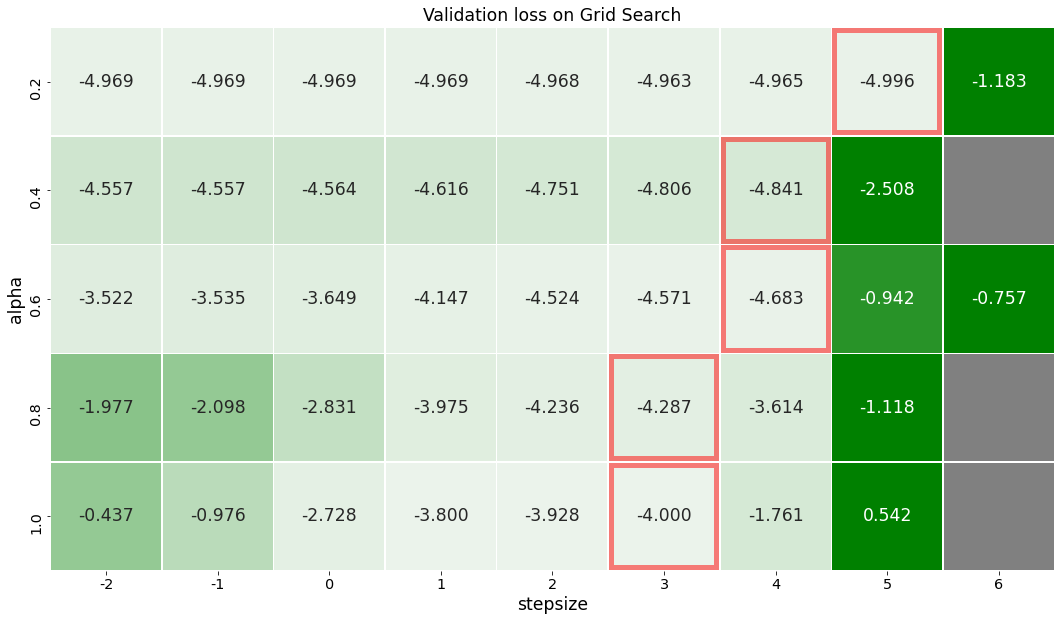

In [310]:
fig, ax = plt.subplots(figsize=(18,10))     
s_exp_mix = sns.heatmap(tab_n, linewidths=.5, cmap=cm, annot=np.log(table_exp_mix), cbar=False, annot_kws={'fontsize': 'xx-large'}, fmt='.3f', mask=tab_n.isnull())
ax.set_title('Validation loss on Grid Search')
ax.axes.set_xlabel('stepsize')
ax.axes.set_ylabel('alpha')
ax.axes.set_facecolor('grey')
ax.figure.patches.extend([plt.Rectangle((0.73,0.734),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig), 
                          plt.Rectangle((0.644,0.583),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.644,0.432),0.081, 0.143, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.558,0.281),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.558,0.130),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.savefig(PLOT_PATH + '/grid_search_{}.pdf'.format(exp_keyword))

/home/gasanoe/anaconda3/envs/explicit_2/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


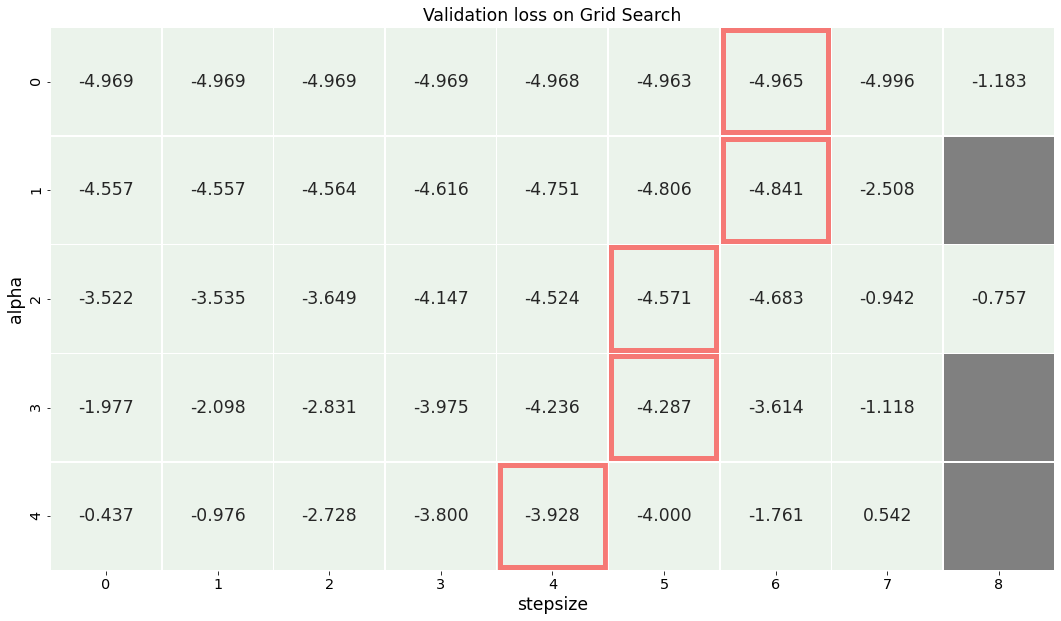

In [277]:
fig, ax = plt.subplots(figsize=(18,10))     
s_exp_mix = sns.heatmap(np.log(table_exp_mix), linewidths=.5, cmap=cm, annot=True, cbar=False, annot_kws={'fontsize': 'xx-large'}, fmt='.3f')
ax.set_title('Validation loss on Grid Search')
ax.axes.set_xlabel('stepsize')
ax.axes.set_ylabel('alpha')
ax.axes.set_facecolor('grey')
ax.figure.patches.extend([plt.Rectangle((0.644,0.734),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig), 
                          plt.Rectangle((0.644,0.583),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.558,0.432),0.081, 0.143, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.558,0.281),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig),
                          plt.Rectangle((0.472,0.130),0.081, 0.142, ec='red', lw=5,
                                  fill=False, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
# fig.savefig(PLOT_PATH + '/grid_search.pdf')

In [115]:
s_exp_mix = df_exp_mix.style.background_gradient(cmap=cm, axis=1)

In [116]:
s_exp_mix

,-2,-1,0,1,2,3,4,5,6
0.2,0.015181,0.015181,0.015181,0.015181,0.015180,0.015164,0.015021,0.023846,0.020088
0.4,0.028716,0.028716,0.028715,0.028709,0.028645,0.028047,0.026871,0.033577,0.042550
0.6,0.078171,0.078170,0.078154,0.078001,0.076521,0.065419,0.068822,0.086977,0.078171
0.8,0.243521,0.243495,0.243237,0.240700,0.218758,0.128166,0.262919,0.243524,0.243524
1.0,0.693122,0.692898,0.690666,0.669155,0.513631,0.673957,0.709051,0.693147,0.693147


In [278]:
arg_mix_exp_mix = np.argmin(table_exp_mix, axis=1)

In [279]:
arg_mix_exp_mix

array([7, 6, 6, 5, 5])

In [81]:
best_explicit_mixture_stepsizes = [Explicit_Mixture_stepsizes(alphas[i], pows)[arg_mix_exp_mix[i]] for i in range(len(alphas))]

In [ ]:
# stepsizes = [2**x for x in range(-8, 17, 4)]

In [ ]:
# best_explicit_mixture_stepsizes = [stepsizes[arg_mix_exp_mix[i]] for i in range(len(alphas))]

In [82]:
best_explicit_mixture_stepsizes

[500000.0, 50000.0, 50000.0, 5000.0, 5000.0]

### FOMAML

In [206]:
table_fomaml

array([[0.64589567, 0.64587641, 0.64568394, 0.64376315, 0.62494392,
        0.47096606, 0.09724102, 0.0182638 ,        inf,        inf],
       [0.37666133, 0.37665668, 0.37661085, 0.37615343, 0.37156805,
        0.32547483, 0.09551335, 0.01829037,        inf,        inf],
       [0.06509009, 0.06509033, 0.06509273, 0.06511655, 0.0653565 ,
        0.06790794, 0.075193  , 0.01874979,        inf,        inf],
       [0.0222166 , 0.02221655, 0.02221602, 0.02221073, 0.02215799,
        0.02165788, 0.01958494, 0.02147328,        inf,        inf],
       [0.01983845, 0.01983839, 0.01983781, 0.01983201, 0.01977427,
        0.01922201, 0.01629181, 0.02134471,        inf,        inf],
       [0.0190393 , 0.01903925, 0.01903876, 0.01903377, 0.01898418,
        0.01851301, 0.01595223, 0.01648733,        inf,        inf],
       [0.17235454, 0.17235053, 0.17231028, 0.17190764, 0.16785864,
        0.13611907, 0.01543681, 0.01489707,        inf,        inf],
       [1.72413712, 1.72409825, 1.7237073

In [207]:
arg_min_f = np.argmin(table_fomaml)
arg_min_outer_f = int(arg_min_f / table_fomaml.shape[1])
arg_min_inner_f = arg_min_f % table_fomaml.shape[1]

In [208]:
arg_min_outer_f

6

In [209]:
arg_min_inner_f

7

In [210]:
best_fomaml_outer = outer_loop_stepsizes[arg_min_outer_f]
best_fomaml_inner = inner_loop_stepsizes[arg_min_inner_f]

In [211]:
best_fomaml_outer

50000.0

In [212]:
best_fomaml_inner

10000

### Reptile

In [248]:
table_reptile

array([[0.64594736, 0.64593017, 0.64573146, 0.64374984, 0.62435911,
        0.4674625 , 0.0969091 , 0.01816739,        inf,        inf],
       [0.37685809, 0.37693673, 0.37686546, 0.37616227, 0.36922114,
        0.30832026, 0.09233995, 0.01766326,        inf,        inf],
       [0.07123748, 0.06532036, 0.06536362, 0.06535517, 0.06527675,
        0.06448189, 0.05512173, 0.01673114,        inf,        inf],
       [0.07043495, 0.02678089, 0.02238381, 0.02235639, 0.02229907,
        0.02175281, 0.01908836, 0.02127916,        inf,        inf],
       [0.06706499, 0.02650001, 0.01978808, 0.01967279, 0.01961085,
        0.01905765, 0.01626699, 0.01699948,        inf,        inf],
       [0.02417   , 0.02462564, 0.01851842, 0.01831019, 0.01826169,
        0.01778881, 0.01538371, 0.01592699,        inf,        inf],
       [0.17199963, 0.17199788, 0.17198163, 0.17181855, 0.17019601,
        0.18307559, 0.03270606, 0.01087915,        inf,        inf],
       [1.71999632, 1.71997953, 1.7198232

In [249]:
arg_min_r = np.argmin(table_reptile)
arg_min_outer_r = int(arg_min_r / table_reptile.shape[1])
arg_min_inner_r = arg_min_r % table_reptile.shape[1]

In [250]:
arg_min_outer_r

6

In [251]:
arg_min_inner_r

7

In [252]:
best_reptile_outer = outer_loop_stepsizes[arg_min_outer_r]
best_reptile_inner = inner_loop_stepsizes[arg_min_inner_r]

In [253]:
best_reptile_outer

50000.0

In [254]:
best_reptile_inner

10000

## Explicit Mixture computations

In [83]:
best_global_models_alpha = np.zeros(shape=(len(alphas), mixed_model.d))

In [84]:
best_global_models_alpha.shape

(5, 5000500)

In [ ]:
# w_0 = np.zeros(mixed_model.d)
# epochs = 500
# task_batch = 'full'
# data_batch = 'full'
# mixed_model.compute_smoothness_min = False

In [85]:
L_max = max(mixed_model.l_s)

In [86]:
L_max

0.3

In [ ]:
class checker_modified_linear:
    def __init__(self, input_size, output_size, alpha):
        self.in_features = input_size
        self.out_features = output_size
        self.weight_shape = (input_size, output_size)
        self.weigh_size = np.prod(self.weight_shape)
        self.alpha = alpha
        
    def forward(self, x, w_local):
        out = F.linear(x, w_local.view(*self.weight_shape).transpose(1, 0))
        out = torch.sigmoid(out)
        return out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
# for i in range(80):
#     worker = mixed_model.workers[i]
#     print(np.linalg.norm(worker.grad(worker.x_train, worker.y_train, worker.w_opt)))

In [87]:
n_iter = 50000

In [89]:
tolerance = 1e-15

In [ ]:
# for counter_alpha, alpha in enumerate(alphas):
#     w_global_numpy = np.zeros(shape=net.weigh_size)
#     w_global = torch.Tensor(w_global_numpy).view(in_features, out_features).transpose(1, 0).requires_grad_(True)
#     net = modified_linear(input_size, d_y, alpha)
#     print_every = 5
#     success_flag = False
#     grad_norm = None
#     for i in range(n_iter):
#         for worker_counter in range(mixed_model.n_workers):
#             out = net(x_trains[worker_counter], w_global, w_opts[worker_counter])
#             loss = criterion(out, y_trains[worker_counter])
#             loss.backward()
#         grad_norm = torch.norm(w_global.grad / mixed_model.n_workers)
#         print('{} / {} grad_norm {}'.format(i, n_iter, grad_norm), end='\r')
#         if grad_norm < tolerance:
#             success_flag = True
#             best_global_models_alpha[counter_alpha] = w_global_numpy
#         with torch.no_grad():
#             w_global -= stepsize * w_global.grad / mixed_model.n_workers
#         w_global.grad = None
#     if not success_flag:
#         best_global_models_alpha[counter_alpha] = w_global_numpy        

In [ ]:
for counter_alpha, alpha in enumerate(alphas):
    print('alpha = {}'.format(alpha))
    if counter_alpha == 0:
        w_global_numpy = np.zeros(shape=param_size)
    else:
        w_global_numpy = copy.deepcopy(best_global_models_alpha[counter_alpha - 1]) # previous solution is a good starting point
    w_global = torch.Tensor(w_global_numpy).view(in_features, out_features).transpose(1, 0).to('cuda').requires_grad_()
    net = modified_linear(input_size, d_y, alpha)
    print_every = 5
    success_flag = False
    grad_norm = None
    stepsize = best_explicit_mixture_stepsizes[counter_alpha]
    for i in range(n_iter):
        [criterion(net(x_trains[i], w_global, w_opts[i]), y_trains[i]).backward() for i in range(n_workers)]
        grad_norm = torch.norm(w_global.grad / mixed_model.n_workers)
        print('{} / {} grad_norm {}'.format(i + 1, n_iter, grad_norm), end='\r')
        if grad_norm < tolerance:
            success_flag = True
            best_global_models_alpha[counter_alpha] = w_global.detach().cpu().numpy().reshape((-1), order='F')
            break
        with torch.no_grad():
            w_global -= stepsize * w_global.grad / mixed_model.n_workers
        w_global.grad = None
    if not success_flag:
        best_global_models_alpha[counter_alpha] = w_global.detach().cpu().numpy().reshape((-1), order='F')   
    print('')

alpha = 0.2


In [ ]:
# # accelerated

# for counter_alpha, alpha in enumerate(alphas):
#     print('alpha = {}'.format(alpha))
#     if counter_alpha == 0:
#         w_global_numpy = np.zeros(shape=param_size)
#     else:
#         w_global_numpy = copy.deepcopy(best_global_models_alpha[counter_alpha - 1]) # previous solution is a good starting point
#     w_global = torch.Tensor(w_global_numpy).view(in_features, out_features).transpose(1, 0).to('cuda').requires_grad_()
#     y_global = w_global.clone()
#     y_global_prev = w_global.clone()
#     net = modified_linear(input_size, d_y, alpha)
#     print_every = 5
#     grad_norm = None
#     stepsize = best_explicit_mixture_stepsizes[counter_alpha]
#     for i in range(n_iter):
#         [criterion(net(x_trains[i], w_global, w_opts[i]), y_trains[i]).backward() for i in range(n_workers)]
#         grad_norm = torch.norm(w_global.grad / mixed_model.n_workers)
#         print('{} / {} grad_norm {}'.format(i + 1, n_iter, grad_norm), end='\r')
#         if grad_norm < tolerance:
#             break
#         with torch.no_grad():
#             y_global = w_global - stepsize * w_global.grad / mixed_model.n_workers
#             w_global = y_global + (i / (i + 3)) * (y_global - y_global_prev)
#             y_global_prev = y_global.clone()
#         w_global.grad = None
#         w_global.requires_grad_(True)
#     best_global_models_alpha[counter_alpha] = w_global.detach().cpu().numpy().reshape((-1), order='F')   
#     print('')

In [ ]:
grads = []
for worker_counter, worker in mixed_model.workers.items():
    grads.append(worker.grad(worker.x_train, worker.y_train, 0.6 * best_global_models_alpha[2] + 0.4 * worker.w_opt))

In [94]:
exp_keyword

'SO_LR_one_cluster_50'

In [ ]:
np.linalg.norm(np.mean(grads, axis=0)) * 0.6

In [ ]:
exp_keyword

In [95]:
with open('models/best_exp_mix_{}.npy'.format(exp_keyword), 'wb') as file:
    np.save(file, best_global_models_alpha)

In [ ]:
# for counter_alpha, alpha in enumerate(alphas):
#     print('-----alpha = {}-----'.format(alpha))
#     print('-----epochs = {}------'.format(epochs))
#     print('-----task_batch = {}------'.format(task_batch))
#     print('-----data_batch = {}------'.format(data_batch))
#     start_time = time.time()
#     mixed_model.sgd_mixed_outer_loop = 1.0 / (L_max * alpha ** 2)
#     mixed_model.change_alpha(alpha)
#     print('Changing specification took {} seconds.'.format(time.time() - start_time))
#     start_time = time.time()
#     print('Calculating the global model...')
#     w = mixed_model.learning(model='expmix', w_0=w_0, epochs=epochs, task_batch=task_batch, data_batch=data_batch)
#     print('Calculation took {} seconds.'.format(time.time() - start_time))
#     best_global_models_alpha[counter_alpha, :] = w
#     with open('best_explicit_mixture_model.npy', 'wb') as table_file:
#         np.save(table_file, best_global_models_alpha)

In [ ]:
# std_stdout = sys.stdout
# with open('training_exp_mix.txt', 'w') as text_file:
#     sys.stdout = text_file
#     for counter_alpha, alpha in enumerate(alphas):
#         print('-----alpha = {}-----'.format(alpha))
#         print('-----epochs = {}------'.format(epochs))
#         print('-----task_batch = {}------'.format(task_batch))
#         print('-----data_batch = {}------'.format(data_batch))
#         start_time = time.time()
#         mixed_model.sgd_mixed_outer_loop = 1.0 / (L_max * alpha ** 2)
#         mixed_model.change_alpha(alpha)
#         print('Changing specification took {} seconds.'.format(time.time() - start_time))
#         start_time = time.time()
#         print('Calculating the global model...')
#         w = mixed_model.learning(model='expmix', w_0=w_0, epochs=epochs, task_batch=task_batch, data_batch=data_batch)
#         print('Calculation took {} seconds.'.format(time.time() - start_time))
#         best_global_models_alpha[counter_alpha, :] = w
#         with open('best_explicit_mixture_model.npy', 'wb') as table_file:
#             np.save(table_file, best_global_models_alpha)
#     sys.stdout = std_stdout

In [ ]:
# std_stdout = sys.stdout
# with open('training_exp_mix.txt', 'w') as text_file:
#     sys.stdout = text_file
#     for counter_alpha, alpha in enumerate(alphas):
#         print('-----alpha = {}-----'.format(alpha))
#         print('-----epochs = {}------'.format(epochs))
#         print('-----task_batch = {}------'.format(task_batch))
#         print('-----data_batch = {}------'.format(data_batch))
#         start_time = time.time()
#         mixed_model.sgd_mixed_outer_loop = best_explicit_mixture_stepsizes[counter_alpha]
#         mixed_model.change_alpha(alpha)
#         print('Changing specification took {} seconds.'.format(time.time() - start_time))
#         start_time = time.time()
#         print('Calculating the global model...')
#         w = mixed_model.learning(model='expmix', w_0=w_0, epochs=epochs, task_batch=task_batch, data_batch=data_batch)
#         print('Calculation took {} seconds.'.format(time.time() - start_time))
#         best_global_models_alpha[counter_alpha, :] = w
#         with open('best_explicit_mixture_model.npy', 'wb') as table_file:
#             np.save(table_file, best_global_models_alpha)
#     sys.stdout = std_stdout

## FOMAML computations

In [213]:
best_fomaml_outer

50000.0

In [214]:
best_fomaml_inner

10000

In [215]:
w_global = None
w_locals = None
out = None

In [216]:
n_iter = 50000

In [217]:
net

In [218]:
x_trains_tr.shape

torch.Size([50, 72, 10001])

In [219]:
w_global_numpy = np.zeros(shape=input_size * d_y)
w_global = torch.Tensor(w_global_numpy).view(input_size, d_y).to('cuda').requires_grad_(False)
w_locals = w_global.clone().detach().repeat(n_workers, 1, 1).to('cuda').requires_grad_()

In [ ]:
w_global_numpy = np.zeros(shape=input_size * d_y)
w_global = torch.Tensor(w_global_numpy).view(input_size, d_y).to('cuda').requires_grad_(False)
w_locals = w_global.clone().detach().repeat(n_workers, 1, 1).to('cuda').requires_grad_()
for i in range(n_iter):
    print('Iteration {} / {}'.format(i + 1, n_iter), end='\r')
    for j in range(mixed_model.fomaml_number_of_inner_steps):
        out = net(x_trains_tr, w_locals)
        loss = criterion(out, y_trains_tr)
        loss.backward()
        with torch.no_grad():
            w_locals -= best_fomaml_inner * mixed_model.n_workers * w_locals.grad
        w_locals.grad = None
    out = net(x_trains_val, w_locals)
    loss = criterion(out, y_trains_val)
    loss.backward()
    with torch.no_grad():
        w_global -= best_fomaml_outer * w_locals.grad.sum(axis=0)
        w_locals[:] = w_global.clone().detach().repeat(n_workers, 1, 1).requires_grad_()
        w_locals.grad = None
best_fomaml_model = w_global.clone().detach().cpu().numpy().reshape((-1))        
del w_global
del w_locals
del out
torch.cuda.empty_cache()

In [224]:
with open('models/best_fomaml_{}.npy'.format(exp_keyword), 'wb') as file:
    np.save(file, best_fomaml_model)

## Reptile computations

In [255]:
best_reptile_inner

10000

In [256]:
best_reptile_outer

50000.0

In [257]:
n_iter = 50000

In [258]:
w_global_numpy = np.zeros(shape=input_size * d_y)
w_global = torch.Tensor(w_global_numpy).view(input_size, d_y).to('cuda').requires_grad_(False)
w_locals = w_global.clone().detach().repeat(n_workers, 1, 1).to('cuda').requires_grad_()
for i in range(n_iter):
    print('Iteration {} / {}'.format(i + 1, n_iter), end='\r')
    for j in range(mixed_model.reptile_number_of_inner_steps):
        out = net(x_trains, w_locals)
        loss = criterion(out, y_trains)
        loss.backward()
        with torch.no_grad():
            w_locals -= best_reptile_inner * mixed_model.n_workers * w_locals.grad
        w_locals.grad = None
    with torch.no_grad():
        w_global += best_reptile_outer * (w_locals - w_global).mean(axis=0) / inner_loop_stepsize / mixed_model.reptile_number_of_inner_steps
        w_locals[:] = w_global.clone().detach().repeat(n_workers, 1, 1).requires_grad_()
        w_locals.grad = None
best_reptile_model = w_global.clone().detach().cpu().numpy().reshape((-1))        
del w_global
del w_locals
del out
torch.cuda.empty_cache()
print('')

Iteration 50000 / 50000


In [259]:
with open('models/best_reptile_{}.npy'.format(exp_keyword), 'wb') as file:
    np.save(file, best_reptile_model)

In [260]:
best_reptile_model

array([-3.744348 , -3.7586856, -3.8322275, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

# Performance on testing dataset

In [ ]:
from sklearn.datasets import load_svmlight_file

In [ ]:
from prep_data import load_data

## FOMAML

In [225]:
best_fomaml = np.load('models/best_fomaml_{}.npy'.format(exp_keyword))

In [226]:
best_fomaml.shape

(5000500,)

In [227]:
best_fomaml_outer

50000.0

In [228]:
best_fomaml_inner

10000

In [229]:
std_out = sys.stdout
with open('calc_fomaml_recall.txt', 'w') as file:
    sys.stdout = file
    fomaml_recall_at_5, _, _ = mixed_model.compute_recall_at_k_local(w=best_fomaml, 
                                                               counter_to_id=counter_to_id, 
                                                               stepsize=best_fomaml_inner,
                                                               k=mixed_model.fomaml_number_of_inner_steps,
                                                               prefix='{}_test'.format(exp_keyword))
    sys.stdout = std_out

In [230]:
fomaml_recall_at_5

0.6220787

## Reptile

In [261]:
best_reptile = np.load('models/best_reptile_{}.npy'.format(exp_keyword))

In [262]:
std_out = sys.stdout
with open('calc_reptile_recall.txt', 'w') as file:
    sys.stdout = file
    reptile_recall_at_5, _, _ = mixed_model.compute_recall_at_k_local(w=best_reptile, 
                                                               counter_to_id=counter_to_id, 
                                                               stepsize=best_reptile_inner,
                                                               k=mixed_model.reptile_number_of_inner_steps,
                                                               prefix='{}_test'.format(exp_keyword))
    sys.stdout = std_out

In [263]:
reptile_recall_at_5

0.59155446

## Explicit Mixture

In [97]:
alphas

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [98]:
alphas = np.insert(alphas, 0, 0)

In [99]:
alphas

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [100]:
explicit_mixture_recall_at_5 = np.zeros(shape=len(alphas))

In [101]:
explicit_mixture_recall_at_5

array([0., 0., 0., 0., 0., 0.])

In [74]:
with open('models/best_exp_mix_{}.npy'.format(exp_keyword), 'rb') as table_file:
    best_explicit_mixture = np.load(table_file)

In [102]:
best_explicit_mixture = copy.deepcopy(best_global_models_alpha)

In [103]:
best_explicit_mixture = np.vstack((np.zeros_like(best_explicit_mixture[0]), best_explicit_mixture))

In [104]:
best_explicit_mixture[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [105]:
best_explicit_mixture.shape

(6, 5000500)

In [106]:
mixed_model.compute_smoothness_min = False
for counter_alpha, alpha in enumerate(alphas):
    mixed_model.change_alpha(alpha)
    explicit_mixture_recall_at_5[counter_alpha], _, _ = mixed_model.compute_recall_at_k_mixture(w=best_explicit_mixture[counter_alpha],
                                                                                          counter_to_id=counter_to_id,
                                                                                          prefix='{}_test'.format(exp_keyword)
                                                                                         )

In [107]:
explicit_mixture_recall_at_5

array([0.88810211, 0.91022491, 0.90343767, 0.88003081, 0.83009869,
       0.76780277])

# Plot

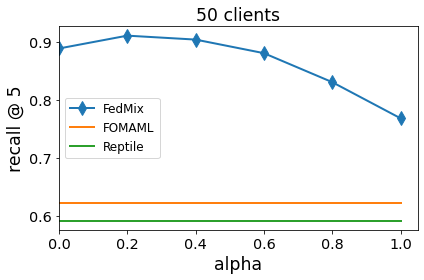

In [267]:
plt.plot(alphas, explicit_mixture_recall_at_5, marker='d', markersize=10, label='FedMix')
plt.plot(np.linspace(0, 1, 10), [fomaml_recall_at_5] * 10, label='FOMAML')
plt.plot(np.linspace(0, 1, 10), [reptile_recall_at_5] * 10, label='Reptile')
plt.ylabel('recall @ 5')
plt.xlabel('alpha')
# plt.title('Two clients, 100 workers')
plt.title('50 clients')
plt.xlim(0)
# plt.ylim(0)
# plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.savefig('plots/{}.pdf'.format(exp_keyword))